## Causal Discovery and Interpretation

In this notebook, we 

* Preprocess the CUB_200_2011 Dataset consisting of ~11,000 images of birds and their species. Currently, we omit analyzing images

* Perform a Rudimentary Sanity Check: See if Causal Discovery methods such as PC identify a correct Causal Graph of a linear model over our system: namely that *Y* is a sink

### Processing the Data

In [ ]:
import numpy as np
import numpy.random as npr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Modeling Imports
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

# Adding some feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Causal Discovery Imports
import pydot
from pycausal import search as s # See install instructions here: https://github.com/bd2kccd/py-causal

from pycausal.pycausal import pycausal as pc
pc = pc()
pc.start_vm() # Start Java vm

In [ ]:
## Load in the Files
data_dir = "../data/CUB_200_2011_no_images/"
attrs = pd.read_csv(data_dir + "CUB_200_2011/attributes/image_attribute_labels.txt", sep = " ",
                    header=None,
                   names = ["image_id", "attr_id", "is_present", "certainty_id", "time"], 
                   error_bad_lines=False) # Two images read incorrectly, we go on

# Transform attr dataframe with no regard for certainty
X = attrs[["image_id", "attr_id","is_present"]].pivot(index="image_id", columns="attr_id", values="is_present")

X = X.reset_index().fillna(0)

# Let's get the Y
Y = pd.read_csv(data_dir + "CUB_200_2011/image_class_labels.txt", header=None, 
               names=["image_id", "class"], sep=" ")

# Combine and Separate to Ensure Same labels
full_df = X.merge(Y, on="image_id", how="inner")

X = full_df.drop(["image_id", "class"], axis=1)
Y = full_df["class"]

### Running Causal Discovery + Modeling

In [5]:
# Experiment: Sample Data, train graph, count how many times Yhat is a sink node
# See this Jupyter Notebook for Tetrad Instructions: 
#     https://github.com/bd2kccd/py-causal/blob/development/example/py-causal%20-%20FCI%20in%20Action.ipynb


runs = 20
size = len(X) # Size of Bootstrap Sample
sparse = True
edges = []
for run in range(0, runs):
    # Init Tetrad
    tetrad = s.tetradrunner()
    
    
    # Bootstrap data
    idx = npr.choice(len(X), size=size, replace=True)
    
    X_train_pre = X.iloc[idx]
    Y_train = Y.iloc[idx]
    
    
#     # One Hot Encode Y_Train
#     onehot_idx = (Y_train - 1).reset_index().values[:, 1]
    
#     Y_train_onehot = np.zeros((len(X_train_pre), Y_train.max()))
#     Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1
    
    X_train_pre = sm.add_constant(X_train_pre)

    # If sparse is true, do some feature selection
    if sparse:
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train_pre, Y_train)
        model_fs = SelectFromModel(lsvc, prefit=True, threshold="0.5*mean")
        X_train = model_fs.transform(X_train_pre)
    else:
        X_train = X_train_pre
        

    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(X_train, Y_train)
    
    Y_hat = model.predict(X_train)
    
#     preds = np.argmax(Y_hat, axis=1) # Line is for one_hot encoding for OLS

    X_train = pd.DataFrame(X_train)
    X_train["Y_hat"] = Y_hat
    
    print("Starting Tetrad FCI for run %s" % run)
    # Perform fci to recover a causal graph
    tetrad.run(algoId = 'fci', dfs = X_train, testId = 'fisher-z-test', 
           depth = -1, maxPathLength = -1, 
           completeRuleSetUsed = True, verbose = True) # set completeRuleSetUsed to false to get PAG
    
    print("Finished Tetrad FCI")
    
    edges.append([edge for edge in tetrad.getEdges() if "Y_hat o->" in edge])

<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 0
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 1
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 2
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 3
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 4
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 5
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 6
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 7
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 8
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 9
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 10
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 11
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 12
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 13
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 14
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 15
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 16
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 17
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 18
Finished Tetrad FCI


<ipython-input-5-4908d4a7e081>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y_train_onehot[[range(0, len(Y_train)), onehot_idx]] = 1


Starting Tetrad FCI for run 19
Finished Tetrad FCI


In [6]:
edges

[['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0'],
 ['Y_hat o-> 0']]

In [7]:
for edge in tetrad.getEdges():
    if "Y_hat" in edge:
        print(edge)

13 <-> Y_hat
11 o-> Y_hat
14 o-> Y_hat
1 <-> Y_hat
2 <-> Y_hat
Y_hat o-> 0
5 <-> Y_hat
Y_hat <-> 6
3 <-> Y_hat
9 <-> Y_hat
7 <-> Y_hat
8 o-> Y_hat


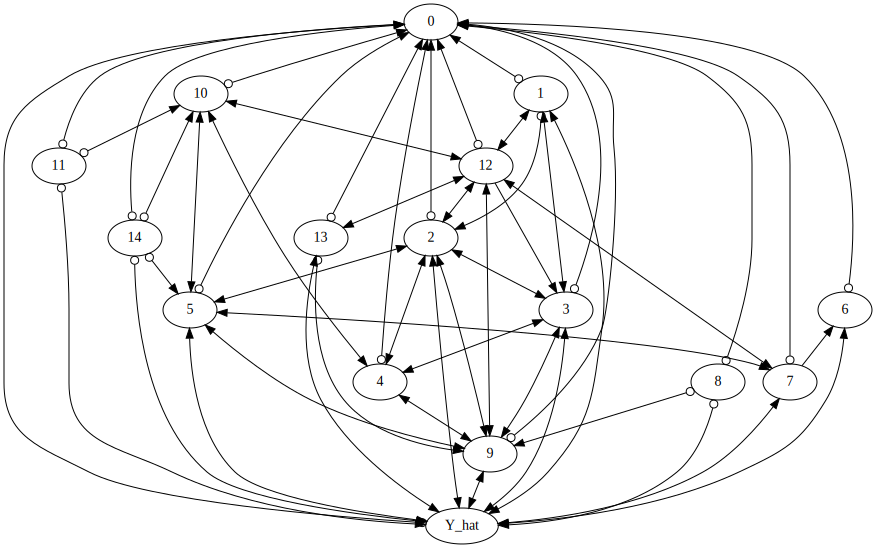

In [8]:
import pydot
from IPython.display import SVG

dot_str = pc.tetradGraphToDot(tetrad.getTetradGraph())
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [ ]:
X_train.shape

In [ ]:
Y_hat

In [ ]:
Y_hat = model.predict_proba(X_train)

In [ ]:
len(Y_hat)

In [ ]:
## Let's get the accuracy
acc = np.sum(Y_train == Y_hat)/len(Y_train)
acc